# SMART Health Cards

This notebook is designed to give an overview of [SMART Health Cards Framework](https://smarthealth.cards/) and how it works.


This notebook is written in JavaScript and uses the [IJavascript kernel](https://github.com/n-riesco/ijavascript) for Jupyter Notebook.

### The FHIR Bundle

A SMART Health Card is composed of a [W3C Verifiable Credential](https://w3c.github.io/vc-data-model/), [encoded as a JWT](https://w3c.github.io/vc-data-model/#jwt-encoding), with a Credential Subject that contains the FHIR version and a FHIR Bundle (See [Modeling W3C Verifiable Credentials in FHIR](https://smarthealth.cards/credential-modeling/).

The FHIR Bundle contains the health care information.

Let's assume we have the below FHIR Bundle ([Example 0](https://smarthealth.cards/examples/example-00-a-fhirBundle.json) at the time of writing). This FHIR Bundle could be produced in a number of ways, but for now let's imagine that the patient, John B. Anyperson, has just received his second COVID-19 vaccination shot and the healthcare worker entered his information into their system which produced the below in their system.

## Walkthrough

The high level outline is as follows:
* FHIR Bundle is created
* FHIR Bundle is minified
* SMART Health Card is created from FHIR Bundle
* SMART Health Card is encoded as a JWS
* Patient Retrieves the SMART Health Cards via:
  * File Download
  * QR Code
  * FHIR API

In [1]:
const fhirBundle = {
  resourceType: "Bundle",
  type: "collection",
  entry: [
    {
      fullUrl: "resource:0",
      resource: {
        resourceType: "Patient",
        name: [
          {
            family: "Anyperson",
            given: ["John", "B."],
          },
        ],
        birthDate: "1951-01-20",
      },
    },
    {
      fullUrl: "resource:1",
      resource: {
        resourceType: "Immunization",
        status: "completed",
        vaccineCode: {
          coding: [
            {
              system: "http://hl7.org/fhir/sid/cvx",
              code: "207",
            },
          ],
        },
        patient: {
          reference: "resource:0",
        },
        occurrenceDateTime: "2021-01-01",
        performer: [
          {
            actor: {
              display: "ABC General Hospital",
            },
          },
        ],
        lotNumber: "0000001",
      },
    },
    {
      fullUrl: "resource:2",
      resource: {
        resourceType: "Immunization",
        status: "completed",
        vaccineCode: {
          coding: [
            {
              system: "http://hl7.org/fhir/sid/cvx",
              code: "207",
            },
          ],
        },
        patient: {
          reference: "resource:0",
        },
        occurrenceDateTime: "2021-01-29",
        performer: [
          {
            actor: {
              display: "ABC General Hospital",
            },
          },
        ],
        lotNumber: "0000007",
      },
    },
  ],
};


A couple things to note in the above JSON. This is a Bundle that contains 3 resources: one for the patient, one for the first vaccination, and another for the second vaccination. This Bundle conforms to the requirements laid out in [SMART Health Cards: Vaccination & Testing Implementation Guide](http://build.fhir.org/ig/dvci/vaccine-credential-ig/branches/main/) which defines what resources should be included in the Health Card. Specifically, this is an example of [Vaccine Credential Bundle - Data Minimization](http://build.fhir.org/ig/dvci/vaccine-credential-ig/branches/main/StructureDefinition-vaccine-credential-bundle-dm.html). We'll talk about what "Data Minimization" means in a second.

Now let's create the "Expanded Health Card".

### Expanded Health Card

The Expanded Health Card shows what the Health Card looks like before it is minified and serialized using the compact JWS serialization.

[Health Cards are encoded as Compact Serialization JSON Web Signatures (JWS)](https://smarthealth.cards/#health-cards-are-encoded-as-compact-serialization-json-web-signatures-jws) and [Modeling W3C Verifiable Credentials in FHIR](https://smarthealth.cards/credential-modeling/) cover this in more detail.

Before we get into the details it's important to note that some of the VC properties are mapped to standard JWT fields when using the [JWT encoding](https://w3c.github.io/vc-data-model/#jwt-encoding) (which we are). These include the `iss` and `nbf` fields.

Below shows the expanded Health Card for the example:

In [2]:
const expandedHealthCard = {
  "iss": "https://smarthealth.cards/examples/issuer",
  "nbf": Date.now() / 1000,
  "vc": {
    "@context": [
      "https://www.w3.org/2018/credentials/v1"
    ],
    "type": [
      "VerifiableCredential",
      "https://smarthealth.cards#health-card",
      "https://smarthealth.cards#immunization",
      "https://smarthealth.cards#covid19"
    ],
    "credentialSubject": {
        "fhirVersion": "4.0.1",
        "fhirBundle": fhirBundle
    }
  }
}

Let's talk about the three root fields:

`iss` - This represents the [Issuer](https://w3c.github.io/vc-data-model/#issuer)
  * Note this property is represented by `iss` according to the [JWT Encoding Rules](https://w3c.github.io/vc-data-model/#jwt-encoding)

`nbf` - This represents the [IssuanceDate](https://w3c.github.io/vc-data-model/#issuance-date)
  * Note this property is represented by `nbf`.

`vc` - This represents the VC claim minus all the unmapped fields (`iss` and `nbf`)


TODO: Fill out the rest of these properties

### Health Cards are Small

SMART Health Cards can be issued on pieces of paper via QR Codes. This introduces some unique size constraints in order to keep the number and size of QR codes manageable. When using and applying SMART Health Cards, it's important to keep them small.

The SMART Health Card spec requires that [the JWS payload is minified and compressed](https://smarthealth.cards/#health-cards-are-small) in order to reduce payload size.

SMART Health Cards are designed to be be atomic and shared as a whole. Information within the Health Card cannot be removed without affecting the verifiability of the Health Card. This imposes a privacy challenge when too much information is included in a single Health Card.

The "Data Minimization" profiles in the IG are designed to address these size and privacy concerns by ensuring the FHIR profiles only require the minimal set of information to achieve the desired results.

Below the JWS Payload (i.e. the "Expanded Health Card") is compressed according to the spec:

In [3]:
// Remove the optional whitespace
const noWhiteSpaceHealthCard = JSON.stringify(expandedHealthCard)
console.log(noWhiteSpaceHealthCard)

{"iss":"https://smarthealth.cards/examples/issuer","nbf":1632578427.472,"vc":{"@context":["https://www.w3.org/2018/credentials/v1"],"type":["VerifiableCredential","https://smarthealth.cards#health-card","https://smarthealth.cards#immunization","https://smarthealth.cards#covid19"],"credentialSubject":{"fhirVersion":"4.0.1","fhirBundle":{"resourceType":"Bundle","type":"collection","entry":[{"fullUrl":"resource:0","resource":{"resourceType":"Patient","name":[{"family":"Anyperson","given":["John","B."]}],"birthDate":"1951-01-20"}},{"fullUrl":"resource:1","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/sid/cvx","code":"207"}]},"patient":{"reference":"resource:0"},"occurrenceDateTime":"2021-01-01","performer":[{"actor":{"display":"ABC General Hospital"}}],"lotNumber":"0000001"}},{"fullUrl":"resource:2","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/si

In [4]:
// Normally we'd remove some of the fhirBundle elements at 
// this step ( e.g. Resource.id, Resource.meta, CodebableConcept.text).
// These are already missing from the original payload, so we'll skip that here

// Compress the payload with DEFLATE, omitting any zlib headers

const compressedPayload = zlib.deflateRawSync(noWhiteSpaceHealthCard)

### Creating the Signed Health Card

Now that we have the compressed payload we can sign it as a JWS. First, let's create the key pair for signing and verifying.

In [5]:
var jose = require('node-jose');

const keystore = jose.JWK.createKeyStore()

let signingKey;

keystore.generate("EC", "P-256").
        then(function(result) {
          // {result} is a jose.JWK.Key
          signingKey = result;
        });

In [6]:
// Print the entire key store, including the `d` member which contains the private key value
// Remove true to just present the public key
// See: https://tools.ietf.org/id/draft-jones-jose-json-private-and-symmetric-key-00.html#rfc.section.3.1.1
keystore.toJSON(true);

{
  keys: [
    {
      kty: 'EC',
      kid: 'vfBH4-CtLiyaZ3_1NmkClN5K9XDUFAjXH9aFwKg7Ujo',
      crv: 'P-256',
      x: 'KpZIu1G3ghpXT5R15oR4ggvYQ02BdXxqAV-L78Ya-UI',
      y: 'u7TuYC-QiwHOSN3cRVyQdQV9CkGVnrFyCT-gus91V98',
      d: 'NuCVPiyPrYwFeRR7Oog2iGd5qJpSfMKE7W_3Mng2u2o'
    }
  ]
}

With a signing key in hand we can create the JWS:

In [7]:
const fields = { zip: 'DEF' }

let jws;

jose.JWS.createSign({ format: 'compact', fields }, signingKey)
    .update(Buffer.from(compressedPayload))
    .final()
    .then(function(result) {
        jws = result;
        console.log(jws)
});

eyJ6aXAiOiJERUYiLCJhbGciOiJFUzI1NiIsImtpZCI6InZmQkg0LUN0TGl5YVozXzFObWtDbE41SzlYRFVGQWpYSDlhRndLZzdVam8ifQ.3VLLbtswEPyVYHu19YpTxTq1doE-DkWBJr0UPtDU2mJBkQJJyXYD_Xt3aTttgMSnnMrbkrOzM8N9AOU9VNCE0PkqTX0rXGhQ6NAkUrjap7gXbafRpwTs0cEEzHoDVf72urgpb2dFmczKYgKDhOoB3klrAu4DVD8fKXe7XbK7TqzbpkWW36bSYY0mKKF9OuSwmkA4dMgdP9CpjRJrjctHDM17UdubYzHl4iJOtW1v1G8RlDUXgdIOqs7nLOqvzO_9-hfKwP42jXKk0jNPBbMkS3Li49tFb2qNjHHobe8k3kVXcHo4uwRptSa2oxIa4A5knZh7re-dJsC5v8oIcC6eIf5GdqifP0S0eCQRrdLEB-8NYZyPM7ZqQMPxfrEN14sEViMZXCsy_0EE5srnN_k0y6dFBuM4eVZNflnN56cR-yBC76Nd3p6A_EGDkFIZXNo6MkhbK7ONwv3BB2xPe0g_0-gyLgwnm3pVp3LYE4GMnVBkJYyrcQLdKYIoZ4MODWv7N0ECWSl7F5_Y7J1qjxRFNJyxLYpqY11Ly81ahAzWMWWtfKdFjHOxvPqIBp3QV5-s71SgxRw5RG3D175dcytk8eQvJlj8lwkW89dOsOSHkc4f.VwJR52HF04oRiq61MCebMLfpammyozgvSw4xbOX0YdQyO1qiAB2xAnlyWMUygHSOvXD7c7pErR42SbLR8tBuiw


Now that we have the JWS we should check that we can actually verify the signature

In [8]:
jose.JWS.createVerify(signingKey)
    .verify(jws).then(function(result) {
    console.log(result)
})

{
  protected: [ 'zip', 'alg', 'kid' ],
  header: {
    zip: 'DEF',
    alg: 'ES256',
    kid: 'vfBH4-CtLiyaZ3_1NmkClN5K9XDUFAjXH9aFwKg7Ujo'
  },
  payload: <Buffer dd 52 cb 6e db 30 10 fc 95 60 7b b5 f5 8a 53 c5 3a b5 76 81 3e 0e 45 81 26 bd 14 3e d0 d4 da 62 41 91 02 49 c9 76 03 fd 7b 77 69 3b 6d 80 c4 a7 9c ca ... 415 more bytes>,
  signature: <Buffer 57 02 51 e7 61 c5 d3 8a 11 8a ae b5 30 27 9b 30 b7 e9 6a 69 b2 a3 38 2f 4b 0e 31 6c e5 f4 61 d4 32 3b 5a a2 00 1d b1 02 79 72 58 c5 32 80 74 8e bd 70 ... 14 more bytes>,
  key: JWKBaseKeyObject {
    keystore: JWKStore {},
    length: 256,
    kty: 'EC',
    kid: 'vfBH4-CtLiyaZ3_1NmkClN5K9XDUFAjXH9aFwKg7Ujo',
    use: '',
    alg: ''
  }
}


Let's also create a fake key and test with that to make sure we aren't getting a false positive

In [9]:
var fakeKey;

keystore.generate("EC", "P-256").
        then(function(result) {
          // {result} is a jose.JWK.Key
          fakeKey = result;
        });

JWKBaseKeyObject {
  keystore: JWKStore {},
  length: 256,
  kty: 'EC',
  kid: 'xA8svdR5-gSPP0Do3rr39GYp5dXFzPQglbhZyirto24',
  use: '',
  alg: ''
}


In [10]:
// Note "Error: no key found" is the generic error message for keys that won't decrypt
// See: https://github.com/cisco/node-jose/issues/262
jose.JWS.createVerify(fakeKey)
    .verify(jws).then(function(result) {
    console.log(result)
})

Error: no key found

### QR Code Generation

Now that we have a JWS we can turn that into a QR Code which can be scanned. We won't worry about chunking just yet since the payload is below the 1195 character threshold in this example, but its a simple addition and [this code snippet](https://github.com/smart-on-fhir/health-cards/blob/152a4f83b223b5fd14027f765e957e290649f2c0/generate-examples/src/index.ts#L146) goes over the process.

In [11]:
// Convert to numeric mode QR

// This code snippet was adapted/taken from https://github.com/smart-on-fhir/health-cards/blob/152a4f83b223b5fd14027f765e957e290649f2c0/generate-examples/src/index.ts#L173
const numericJWS = jws.split('')
    .map((c) => c.charCodeAt(0) - 45)
    .flatMap((c) => [Math.floor(c / 10), c % 10])//Need to maintain leading zeros 
    .join('')

const qrCodeData = 'shc:/' + numericJWS

console.log(qrCodeData)

shc:/56762909524320603460292437404460312229595326546034602925407728043360287028647167452228092865456436625803314033033926630844416677437725345342712353240704387763443725412636426744382363593765553145775541526411605736010641313153717074243576414427720412446739753968045566240023624221296903403571234005642921623629297643442350437106523971715832386565326953626934773211331220344012413322240335626839430369432659360933206240696152671058435352573767743970035424247727662341571005726958675305552564547730445830235934662106626369207207234123115730435610435330103968775367624242060953384444036430302512347238746462200755325855351222676137296961547127233204104055725344772763076029347142047304261137632340435855283468701065313468737734501200595730743507056143306203613335215332623806316007127125530568336127276653561162066241435427660772743767713852056675285207200862654559106956005529702208731166285422095628570826556860573503380356223637695531242100113344457635321045683632357557692433040770244160324543227

The above shows what the value of the QR code will be, with the leading `byte` segment and the `numeric` segment following

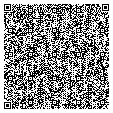

In [12]:
var QRCode = require('qrcode')

const segments = [
    {data: 'shc:/', mode: 'byte'},
    {data: numericJWS, mode: 'numeric'}
]

let qrSVG
QRCode.toString(segments,{type: 'svg', errorCorrectionLevel: 'low', version: 22 }).then(function(result){
    qrSVG = result
    $$.svg(qrSVG)
})

// Also print as PNG for scanning later on.


QRCode.toFile('./qrcode.png', segments, {width: 800, version: 22})

### QR Code Scanning

Now let's try and scan the QR Code!

In [13]:
var jsQR = require('jsqr');
var PNG = require('pngjs').PNG;


imageData = PNG.sync.read(fs.readFileSync('./qrcode.png'))

const scannedQR = jsQR(new Uint8ClampedArray(imageData.data.buffer), imageData.width, imageData.height)

const qrCodesEqual = scannedQR.data === qrCodeData

console.log("Are the QR Codes Equal? " + qrCodesEqual)

console.log(scannedQR.data)

Are the QR Codes Equal? true
shc:/567629095243206034602924374044603122295953265460346029254077280433602870286471674522280928654564366258033140330339266308444166774377253453427123532407043877634437254126364267443823635937655531457755415264116057360106413131537170742435764144277204124467397539680455662400236242212969034035712340056429216236292976434423504371065239717158323865653269536269347732113312203440124133222403356268394303694326593609332062406961526710584353525737677439700354242477276623415710057269586753055525645477304458302359346621066263692072072341231157304356104353301039687753676242420609533844440364303025123472387464622007553258553512226761372969615471272332041040557253447727630760293471420473042611376323404358552834687010653134687377345012005957307435070561433062036133352153326238063160071271255305683361272766535611620662414354276607727437677138520566752852072008626545591069560055297022087311662854220956285708265568605735033803562236376955312421001133444576353210456836323575

### Extracting Data from the QR Code

Now let's reverse the process to get the original data back and check the signature. First, let's extract the JWS.

In [14]:
const scannedJWS = scannedQR
    .chunks
    .filter(chunk => chunk.type === "numeric")[0] // Grab the numeric chunk
    .text.match(/(..?)/g) // Split into groups of 2 numeric characters each of which represent a single JWS char
    .map(num => String.fromCharCode(parseInt(num, 10) + 45)).join('') // Convert from numeric encoding to JWS

console.log(scannedJWS)

eyJ6aXAiOiJERUYiLCJhbGciOiJFUzI1NiIsImtpZCI6InZmQkg0LUN0TGl5YVozXzFObWtDbE41SzlYRFVGQWpYSDlhRndLZzdVam8ifQ.3VLLbtswEPyVYHu19YpTxTq1doE-DkWBJr0UPtDU2mJBkQJJyXYD_Xt3aTttgMSnnMrbkrOzM8N9AOU9VNCE0PkqTX0rXGhQ6NAkUrjap7gXbafRpwTs0cEEzHoDVf72urgpb2dFmczKYgKDhOoB3klrAu4DVD8fKXe7XbK7TqzbpkWW36bSYY0mKKF9OuSwmkA4dMgdP9CpjRJrjctHDM17UdubYzHl4iJOtW1v1G8RlDUXgdIOqs7nLOqvzO_9-hfKwP42jXKk0jNPBbMkS3Li49tFb2qNjHHobe8k3kVXcHo4uwRptSa2oxIa4A5knZh7re-dJsC5v8oIcC6eIf5GdqifP0S0eCQRrdLEB-8NYZyPM7ZqQMPxfrEN14sEViMZXCsy_0EE5srnN_k0y6dFBuM4eVZNflnN56cR-yBC76Nd3p6A_EGDkFIZXNo6MkhbK7ONwv3BB2xPe0g_0-gyLgwnm3pVp3LYE4GMnVBkJYyrcQLdKYIoZ4MODWv7N0ECWSl7F5_Y7J1qjxRFNJyxLYpqY11Ly81ahAzWMWWtfKdFjHOxvPqIBp3QV5-s71SgxRw5RG3D175dcytk8eQvJlj8lwkW89dOsOSHkc4f.VwJR52HF04oRiq61MCebMLfpammyozgvSw4xbOX0YdQyO1qiAB2xAnlyWMUygHSOvXD7c7pErR42SbLR8tBuiw


Next we can verify the signature and extract the payload

In [15]:
let scannedResult;

jose.JWS.createVerify(signingKey)
    .verify(jws).then(function(result) {
    zlib.inflateRaw(result.payload, function(err, decompressedResult){
        scannedResult = decompressedResult.toString('utf8')
    })
})

In [16]:
scannedResult

'{"iss":"https://smarthealth.cards/examples/issuer","nbf":1632578427.472,"vc":{"@context":["https://www.w3.org/2018/credentials/v1"],"type":["VerifiableCredential","https://smarthealth.cards#health-card","https://smarthealth.cards#immunization","https://smarthealth.cards#covid19"],"credentialSubject":{"fhirVersion":"4.0.1","fhirBundle":{"resourceType":"Bundle","type":"collection","entry":[{"fullUrl":"resource:0","resource":{"resourceType":"Patient","name":[{"family":"Anyperson","given":["John","B."]}],"birthDate":"1951-01-20"}},{"fullUrl":"resource:1","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/sid/cvx","code":"207"}]},"patient":{"reference":"resource:0"},"occurrenceDateTime":"2021-01-01","performer":[{"actor":{"display":"ABC General Hospital"}}],"lotNumber":"0000001"}},{"fullUrl":"resource:2","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/s

Let's compare this to our original minified payload with whitespace removed

In [17]:
scannedResult === noWhiteSpaceHealthCard

true

Finally, lets print the entries for easy inspection.

In [18]:
const entries = JSON.parse(scannedResult)
    .vc.credentialSubject.fhirBundle.entry
    .map(entry => console.log(JSON.stringify(entry, null, 2)))

{
  "fullUrl": "resource:0",
  "resource": {
    "resourceType": "Patient",
    "name": [
      {
        "family": "Anyperson",
        "given": [
          "John",
          "B."
        ]
      }
    ],
    "birthDate": "1951-01-20"
  }
}
{
  "fullUrl": "resource:1",
  "resource": {
    "resourceType": "Immunization",
    "status": "completed",
    "vaccineCode": {
      "coding": [
        {
          "system": "http://hl7.org/fhir/sid/cvx",
          "code": "207"
        }
      ]
    },
    "patient": {
      "reference": "resource:0"
    },
    "occurrenceDateTime": "2021-01-01",
    "performer": [
      {
        "actor": {
          "display": "ABC General Hospital"
        }
      }
    ],
    "lotNumber": "0000001"
  }
}
{
  "fullUrl": "resource:2",
  "resource": {
    "resourceType": "Immunization",
    "status": "completed",
    "vaccineCode": {
      "coding": [
        {
          "system": "http://hl7.org/fhir/sid/cvx",
          "code": "207"
        }
      ]
    },
